**INSTALLS**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
setUser = 'Arian'
%cd /content/drive/MyDrive/GT/ML Team Project

/content/drive/.shortcut-targets-by-id/1J4fu7fH7MuRzcUS_y9yU_1iMrJSkUpbS/ML Team Project


In [4]:
!pip install -q -U tensorflow_decision_forests
!pip install -q -U dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from dtreeviz.utils import extract_params_from_pipeline
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import export_graphviz
import graphviz
import dtreeviz
from IPython import display
import numpy as np
import itertools

# avoid "Arial font not found" warnings
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

display.set_matplotlib_formats('retina')

<ipython-input-5-f51e3f925030>:28: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


**HELPER FUNCTIONS**

Function 1: Cleans Data based off of Z-score [working]

In [6]:
# This functions removes all rows from the DataFrame df whose feature value has z-score above 3 or below -3
def remove_outliers_Z_score(df: pd.DataFrame, feature: str):
    z_scores = np.abs(stats.zscore(df[feature]))
    too_high_indices =  np.where(z_scores > 3)[0]
    too_low_indices = np.where(z_scores < -3)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 2: Cleans Data based off of IQR [not working]

In [7]:
# This function removes all rows from the DataFrame df whose feature value is above Q3 + 1.5 * IQR or below Q1 - 1.5 * IQR
# UPDATE: This is giving me issues. Probably better to use Z-score to remove outliers for this dataset
def remove_outliers_IQR(df: pd.DataFrame, feature: str):
    Q1 = np.percentile(df[feature], 25, method = 'midpoint')
    Q3 = np.percentile(df[feature], 75, method = 'midpoint')
    IQR = Q3 - Q1
    too_high_indices = np.where(df[feature] >= Q3 + 1.5 * IQR)[0]
    too_low_indices = np.where(df[feature] <= Q1 - 1.5 * IQR)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 3: Splits pandas DataFrame into training set and testing set

In [8]:
# This function splits a pandas DataFrame into a training set and a test set, specificed by the train_ratio.
def split_dataset(df: pd.DataFrame, train_ratio: float):
  train_indices = np.random.rand(len(df)) < train_ratio
  return df[train_indices], df[~train_indices]

**LOAD DATA**

In [9]:
if setUser == 'Arian':
  property_and_user_activity_df = pd.read_csv("/content/drive/MyDrive/GT/ML Team Project/Datasets/kaggle-rental-properties/property_and_user_activity.csv")
elif setUser == 'Sean':
  property_and_user_activity_df = pd.read_csv("/content/drive/MyDrive/ML4641_Team1/Datasets/kaggle-rental-properties/property_and_user_activity.csv")


<ipython-input-9-673c1603639b>:2: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.


**VISUALIZE DATA**

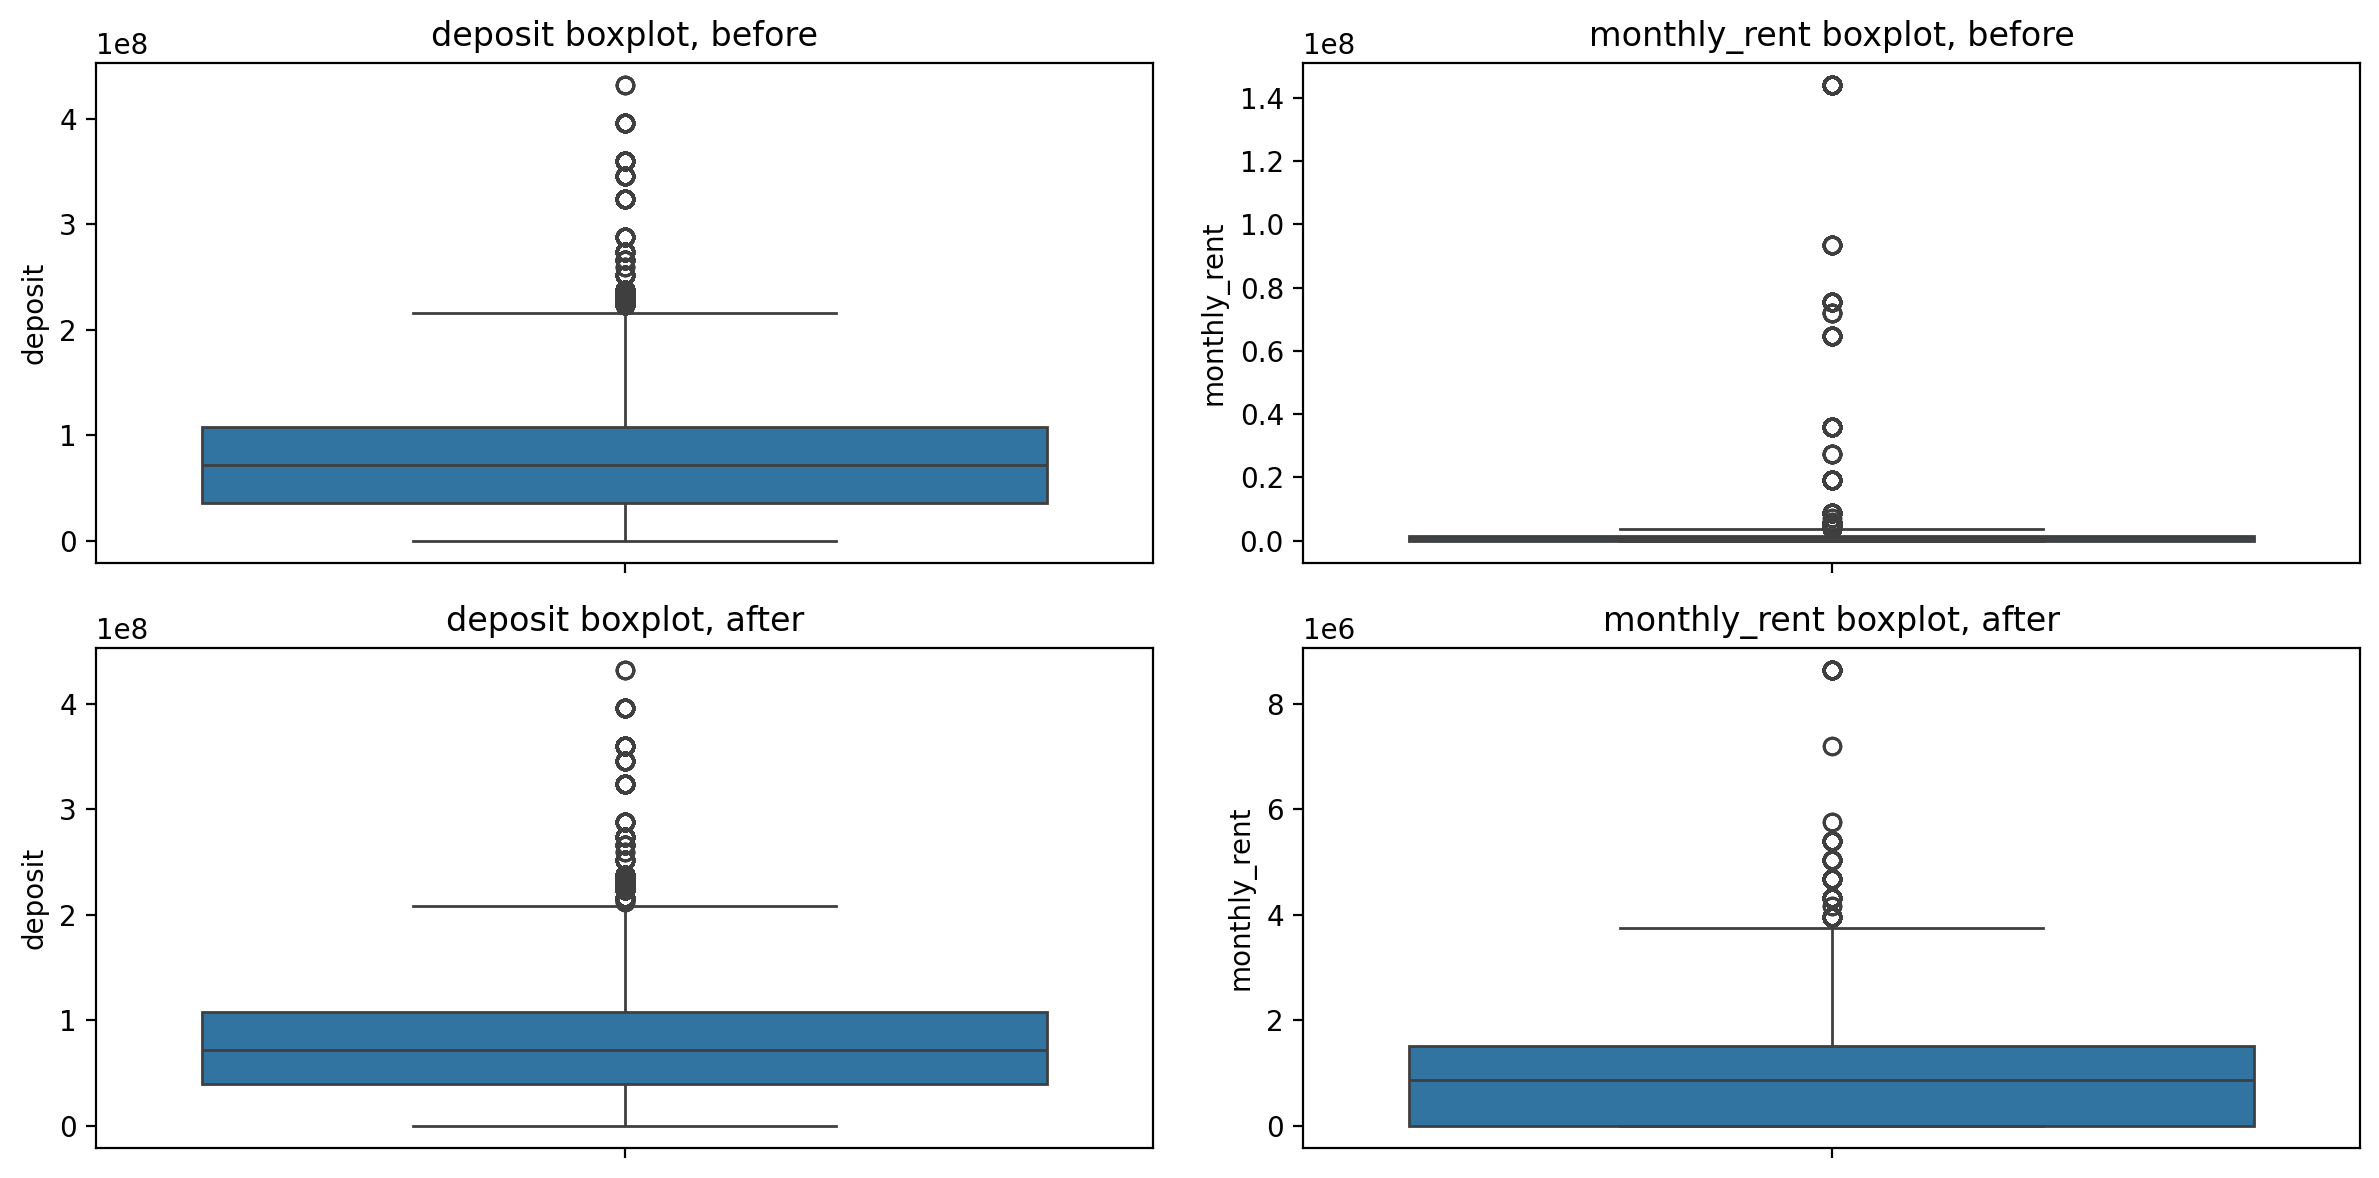

In [10]:
# Visualize the data- this will be helpful in removing outliers later

plt.figure(figsize=(12, 6))

# First Boxplot
plt.subplot(2, 2, 1)  # 2 row, 2 columns, first subplot
sns.boxplot(property_and_user_activity_df['deposit'])
plt.title('deposit boxplot, before')

# Second Boxplot
plt.subplot(2, 2, 2)  # 1 row, 2 columns, second subplot
sns.boxplot(property_and_user_activity_df['monthly_rent'])
plt.title('monthly_rent boxplot, before')

clean_copy = property_and_user_activity_df.copy()
remove_outliers_Z_score(clean_copy, 'deposit')
remove_outliers_Z_score(clean_copy,'monthly_rent')

# Third Boxplot
plt.subplot(2, 2, 3)  # 1 row, 2 columns, first subplot
sns.boxplot(clean_copy['deposit'])
plt.title('deposit boxplot, after')

# Fourth Boxplot
plt.subplot(2, 2, 4)  # 1 row, 2 columns, second subplot
sns.boxplot(clean_copy['monthly_rent'])
plt.title('monthly_rent boxplot, after')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


**CLEAN AND TRAIN**

In [11]:
print("-----STARTING-----\n")

######################################
########### Clean the data ###########
######################################

# Convert text to numbers via one-hot encoding. Then we can handle missing data
encoder = OneHotEncoder()

# Encode event_type to 1 if it gives reasonable indication that the user would like to rent the house.
property_and_user_activity_df['event_type_num'] = property_and_user_activity_df['event_type'].map(lambda x: 1 if x in ['deal-success', 'meeting-success', 'visit-success', 'visit-new'] else 0)

# Encode categorical variables

property_and_user_activity_df['has_elevator'] = property_and_user_activity_df['has_elevator'].astype('category')
property_and_user_activity_df['elevator'] = property_and_user_activity_df['has_elevator'].cat.codes

property_and_user_activity_df['has_storage_area'] = property_and_user_activity_df['has_storage_area'].astype('category')
property_and_user_activity_df['storage'] = property_and_user_activity_df['has_storage_area'].cat.codes


property_and_user_activity_encoded = pd.DataFrame(encoder.fit_transform(
    property_and_user_activity_df[['event_type_num']]).toarray())

property_and_user_activity_encoded = property_and_user_activity_df.join(property_and_user_activity_encoded)

# Fill all missing values with the mode of their respective column
property_and_user_activity_encoded = property_and_user_activity_df.fillna(property_and_user_activity_df.mode().iloc[0])

##### DO WE STILL WANT TO DROP ROWS WHERE RENT IS ZERO? #####

property_and_user_activity_df = pd.read_csv("/content/drive/MyDrive/GT/ML Team Project/Datasets/kaggle-rental-properties/property_and_user_activity.csv")

############################################################################
########### Now the data is cleaned, and we can train our model. ###########
############################################################################

# Split the data (80% for training, 20% for testing)
features = ["room_qty", "unit_area", "elevator", "building_floor_count", "storage"]
target = "event_type_num"
train_set, test_set = split_dataset(property_and_user_activity_encoded, 0.8)

# Only keep the features we want to study.
train_set_with_kept_features = train_set[features + [target]]
test_set_with_kept_features = test_set[features + [target]]

# Convert to TensorFlow datasets
train_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(train_set_with_kept_features, label=target)
test_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(test_set_with_kept_features, label=target)

# Train the model
dt_model = tfdf.keras.RandomForestModel(verbose=0, random_seed=1234)
dt_model.fit(train_tf_set)

-----STARTING-----



<ipython-input-11-7604c635e1d9>:32: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.


**ACCURACY AND METRICS - ARIAN**

In [12]:
# Evaluate accuracy
dt_model.compile(metrics=["accuracy", "precision", "recall"])
# Evaluate the model
results = dt_model.evaluate(test_tf_set, return_dict=True, verbose=0)
print(results)

# Obtain predictions and actual labels
y_pred = []
y_true = []
for batch in test_tf_set:
    inputs, labels = batch
    preds = dt_model.predict(inputs)
    preds = np.argmax(preds, axis=1)
    y_pred.extend(preds)
    labels = np.argmax(labels, axis=1)
    y_true.extend(labels)

# Compute and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Pretty print the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("\n-----FINISHED-----")


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tensorflow_decision_forests/keras/core_inference.py", line 546, in test_function  *
        return step_function_trained(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/tensorflow_decision_forests/keras/core_inference.py", line 525, in run_step  *
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1917, in test_step  *
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1246, in compute_metrics  *
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 620, in update_state  *
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/metrics/base_metric.py", line 153, in decorated  *
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/metrics/base_metric.py", line 140, in update_state_fn  *
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/metrics/base_metric.py", line 722, in update_state  *
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


**DISPLAY RESULTS**

In [ ]:

# Helpful Links:
# https://www.tensorflow.org/decision_forests/tutorials/dtreeviz_colab
# https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/dtreeviz_colab.ipynb#scrollTo=UU8lDr622ZWi

# Right now, I have good accuracy from training the decision tree in the above cell. However, I'm still not getting any visualization.

print("-----STARTING-----")

dt_visualization = dtreeviz.model(dt_model,
                           tree_index=3,
                           X_train=train_set[features],
                           y_train=train_set[target],
                           feature_names=features,
                           target_name=target,
                           class_names=list(property_and_user_activity_encoded[target].unique()))

dt_visualization.save("/content/drive/MyDrive/ML4641_Team1/decision_tree_visualization.jpg")

print("\n-----FINISHED-----")